# Building RNN with Pytorch

Dans ce TD, nous allons construire un RNN from scratch avec Pytorch, en suivant les étapes suivantes:
1. Sur un problème linéaire, nous allons utiliser les torch optimizers pour trouver le paramètre de régression idéal
2. Sur un problème non-linéaire, nous allons construire un multi-layers perceptron
3. Sur un problème de texte, nous allons construire un modèle RNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm

## Optimizers

### Données example
Nous allons construire des données $y = \beta^* X + b$


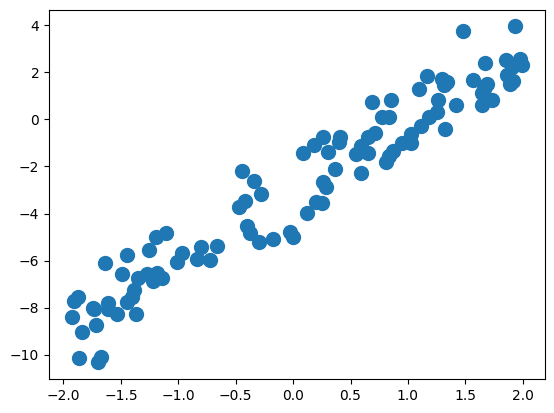

In [2]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * x + b_star + noise
y = torch.tensor(y, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

### Constuire l'optimizer

- Avec torch.nn.Parameter(), créer le paramètre beta qui sera optimisé. Les predictions du modèle sont égales à $\beta \times X$ 
- Avec torch.nn.MSELoss, déclarer la loss entre les prédictions et le résultat réel. loss.backward() pour mettre à jour les gradients
- Avec torch.optim.Adam, déclarer un optimizer
- Construisez la boucle qui, pour n_epochs, va reset les gradients, calculer la loss, mettre à jour les gradients et faire un pas pour optimiser beta

In [3]:
beta = torch.nn.Parameter(torch.tensor(0.))
bias = torch.nn.Parameter(torch.tensor(0.))
optimizer = torch.optim.Adam([beta, bias], lr=0.1)
loss_fn = torch.nn.MSELoss()
n_epochs = 1000

In [4]:
for i in range(n_epochs):
    optimizer.zero_grad()
    y_pred = beta * x + bias * 1
    
    loss = loss_fn(y_pred, y) #'int' object is not callable
    
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print("Loss: ", loss.item())

Loss:  22.048818588256836
Loss:  0.9817038178443909
Loss:  0.9808752536773682
Loss:  0.9808753132820129
Loss:  0.9808751940727234
Loss:  0.9808751940727234
Loss:  0.9808751940727234
Loss:  0.9808751940727234
Loss:  0.9808751940727234
Loss:  0.9808751940727234


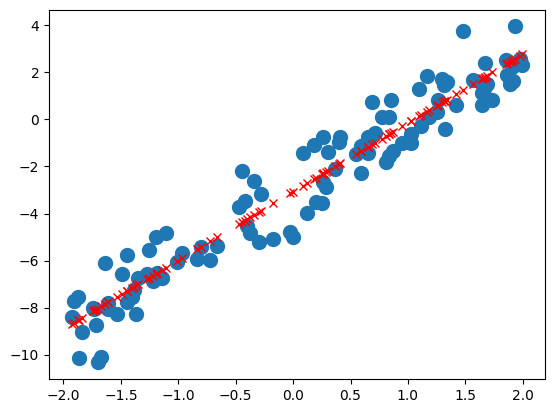

In [5]:
# Plot des predictions
plt.plot(x, y, 'o', markersize=10)
plt.plot(x, (beta * x + bias * 1).detach().numpy(), 'rx')

## Construire un multi-layer perceptron (MLP)

Ici, les données sont $y = a x^2 + b$

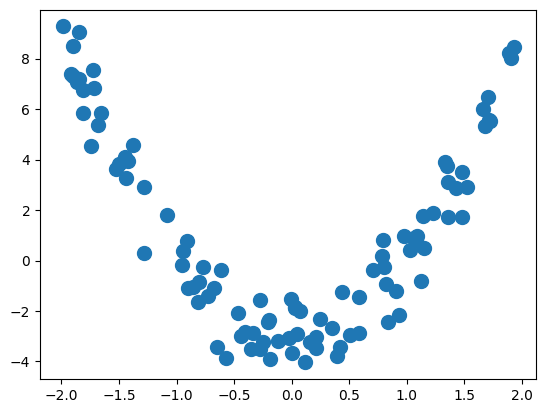

In [6]:
n = 100

a_star = 3.
b_star = -3.
noise_std = 1

x = (np.random.rand(n, 1) - 0.5) * 4
noise = np.random.normal(0, noise_std, (n, 1))
y = a_star * (x ** 2) + b_star + noise
y = torch.tensor(y, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)

xvec = x
plt.plot(x, y, 'o', markersize=10)

Nous allons construire un Pytorch modèle. Dans ce framework, on définit la fonction "forward" qui prend en argument les inputs et retourne les prédictions.

A l'aide de torch.nn.Module et de différentes layers (torch.nn.Linear, torch.nn.ReLU), terminez la classe ci-dessous pour créer un multi-layers perceptron 

In [7]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        prev_size = input_size
        
        self.hidden_layers = []
        for hidden_size in hidden_sizes[1:]:
            self.hidden_layers.append(torch.nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
            
        self.out_layer = torch.nn.Linear(prev_size, output_size)

    def forward(self, X):
        for layer in self.hidden_layers:
            X = layer(X)
            X = torch.nn.ReLU()(X)
        X = self.out_layer(X)
        return X

En utilisant le travail précédent, faite une cellule utilisant un torch optimizer pour optimiser le MLP 

In [8]:
model = MLP(1, [10, 10], 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()
n_epochs = 1000

In [9]:
for i in range(n_epochs):
    optimizer.zero_grad()
    y_pred = model(x)
    
    loss = loss_fn(y_pred, y) #'int' object is not callable
    
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print("Loss: ", loss.item())

Loss:  16.748445510864258
Loss:  1.1239467859268188
Loss:  0.9993503093719482
Loss:  0.9784355759620667
Loss:  0.9662895202636719
Loss:  0.9548298716545105
Loss:  0.9442161321640015
Loss:  0.9346530437469482
Loss:  0.9262115359306335
Loss:  0.9188752770423889


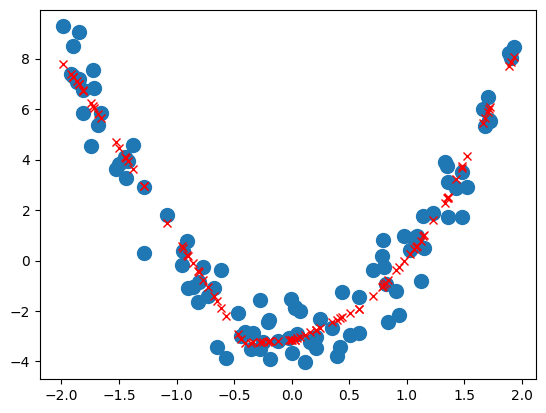

In [10]:
# Plot des predictions
plt.plot(x, y, 'o', markersize=10)
plt.plot(x, model(x).detach().numpy(), 'rx')

## Construire un Recurrent Neural Network (RNN) from scratch

### Données
 
Téléchargez [ici](https://download.pytorch.org/tutorial/data.zip) un jeu de données "nom" -> pays d'origine du nom.
Les noms de chaque pays sont dans leur fichier texte "[country].txt"

A partir de ces données, créez X la liste des noms et y le pays d'origine de chaque nom

### Aide pour générer les données

A la fin de ce code, on lit les noms et leur pays d'origine.<br>
On a une fonction randomTrainingExample, qui génère le pays d'origine et le nom (en texte), puis l'ID de ce pays et le tenseur représetant le nom. <br>

A partir de là, vous pouvez générer les données X, y comme vous voulez

In [11]:
# Code pour générer le jeu de données
# En admettant que les fichiers ont été extraits dans data/raw/names/

import math
import numpy as np
from pathlib import Path
import random
import string
import time
import unicodedata

path = Path("../src/data/raw/td2/names")

In [12]:
def read_names(path):
    category_lines = {}
    for file in path.iterdir():
        if not file.name.endswith(".txt"):
            continue
            
        with open(file) as f:
            names = [unicodeToAscii(line.strip()) for line in f]
        
        category = file.stem
        category_lines[category] = names

    return category_lines

# Handling ASCII stuff
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [13]:
category_lines = read_names(path)
all_categories = list(category_lines.keys())
n_categories = len(all_categories)

In [14]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [15]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Dan
category = English / line = Flanagan
category = Polish / line = Gomolka
category = Czech / line = Kopp
category = Czech / line = Chilar
category = Polish / line = Koziol
category = Greek / line = Tsahalis
category = Vietnamese / line = Mai
category = Italian / line = Benvenuti
category = Greek / line = Houlis


### Construire le RNN

Un Recurrent Neural Network prend, pour prédire un input X et un hidden state H.<br>
Il output une prédiction et un nouvel hidden state pour la prochaine étape.<br>
Nous allons construire un modèle:

$f(name, H_0) = (proba(\mbox{name from country 0}), proba(\mbox{name from country 1}), \dots)$

Avec $H_0$ un hidden state initial (qui sera appris).

Pour l'instant, nous allons construire un RNN linéaire.<br>
Comme pour le MLP, construisez un torch.nn.Module:
- A l'init, la classe prendra les arguments input_size, hidden_state_dim, output_size
- L'init déclare un paramètre pour l'hidden state initial $H_0$, une layer linéaire prenant (input, hidden_state) -> output_size
- Le forward fonctionnera ainsi:
    - hidden_state = $H_0$
    - For letter in name:
        - x = one-hot encode (letter)
        - output, hidden_state = linear_layer(x, hidden_state)
    - return softmax(output)


In [16]:
class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.hidden_layer = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.out_layer = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        # start RNN
        hidden_state = torch.zeros(self.hidden_size).to("cuda")
        for x in X: # cell computation for each letter
            x = torch.cat((x, hidden_state))
            hidden_state = self.hidden_layer(x)
            hidden_state = torch.nn.functional.relu(hidden_state)
        # end RNN
        output = self.out_layer(hidden_state)
        return torch.nn.functional.log_softmax(output, dim=-1)

A l'aide de la negative log likelihood (torch.nn.NLLLoss), construisez une boucle optimisant ce modèle (optimizer, itération au sein des examples).

**Attention 1:** Ici, on n'a pas des tenseurs X, y. On va prendre les exemples 1 par 1.<br>
**Attention 2:** Si le modèle apprend les examples dans l'ordre (d'abord tous les noms arabes, puis tous les chinois, puis tous les tchèques, etc), cela changera grandement le résulat (et le modèle sera très mauvais)

In [17]:
loss_fn = torch.nn.NLLLoss().to("cuda")
model = RNN(n_letters, 128, n_categories).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
n_epochs = 10000

In [18]:
loss_history = []
loss_temp_history = []
iterator = tqdm(range(n_epochs))
for i in iterator:
    
    category, line, category_tensor, line_tensor = randomTrainingExample()
    optimizer.zero_grad()
    y_pred = model(line_tensor[:, 0, :].to("cuda"))
    # category_tensor to one-hot
    category_tensor = torch.zeros((n_categories), dtype=torch.long)
    category_tensor[all_categories.index(category)] = 1.0
    loss = loss_fn(y_pred, category_tensor.to("cuda"))
    loss.backward()
    optimizer.step()
    loss_temp_history.append(loss.item())
    
    if i % 100 == 0:
        loss_history.append(np.mean(loss_temp_history))
        iterator.set_description("Loss: %s" % loss_history[-1])
        loss_temp_history = []
        # print("Loss: ", loss.item())

  0%|          | 0/10000 [00:00<?, ?it/s]

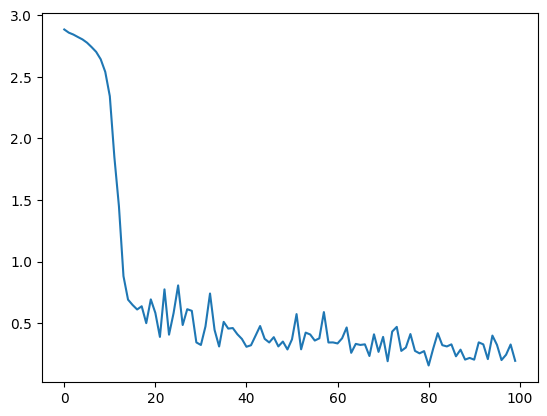

In [19]:
# Plot history
plt.plot(loss_history)
# set y max to 3

## Utilisez les RNNs de Pytorch

Sur le même jeu de données, nous allons utiliser les RNNs déjà codés par Pytorch.<br>

### Padding

Nous voulons aussi utiliser des tenseurs X et y pour utiliser data loader pour les batchs, etc


Avec du padding, créer un tenseur X de la taille (nb_data, name_max_length, vocab_size). <br>
X[i, j, :] contient le one-hot encode de la j-ème lettre du i-ème prénom. Si le i-ème prénom a moins de j lettre, alors X[i, j, :] est un vecteur nul

In [20]:
# category_lines
max_len = 19

category_index = { word:index for index, word in enumerate(all_categories)}

all_values = np.concatenate(list(category_lines.values()))
X = torch.zeros((len(all_values), max_len, len(all_letters)), dtype=torch.float32)
y = torch.zeros((len(all_values), len(all_categories)), dtype=torch.long)
step = 0
for key, value in category_lines.items():
    for i, word in enumerate(value):
        for j, letter in enumerate(word):
            if j < max_len:
                X[step, j, letterToIndex(letter)] = 1.0
        y[step, category_index[key]] = 1.0
        step += 1
    

In [21]:
y.shape, X.shape

(torch.Size([20074, 18]), torch.Size([20074, 19, 57]))

In [22]:
# create a tensor dataset
dataset = torch.utils.data.TensorDataset(X, y)
# create a data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

### Modèle

Construisez un modèle qui:
- A l'init, déclare un hidden state initial $H_0$, un RNN (avec torch.nn.RNN)
- Au forward, passe (input, $H_0$) dans le RNN, puis applique un softmax à l'output

In [23]:
class RNNNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.rnn = torch.nn.RNN(input_size, hidden_size, batch_first=False)
        self.out_layer = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        # start RNN
        output, hidden_state = self.rnn(X)
        # end RNN
        output = self.out_layer(output)
        return torch.nn.LogSoftmax()(output)

In [24]:
model = RNNNetwork(n_letters, 128, n_categories).to("cuda")
loss_fn = torch.nn.CrossEntropyLoss().to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10

In [25]:
loss_history = []
for i in range(n_epochs):
    for X_batch, y_batch in tqdm(data_loader):
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
    
    
    loss_history.append(loss.item())
    print("Loss: ", loss.item())

  0%|          | 0/157 [00:00<?, ?it/s]

/home/dev/miniconda3/envs/nlp-td2/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss:  2.9405598640441895


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  2.9322688579559326


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  2.415525197982788


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.8494997620582581


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.4247192144393921


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.36831188201904297


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.36994469165802


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.40401849150657654


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.3613649010658264


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.3936316668987274


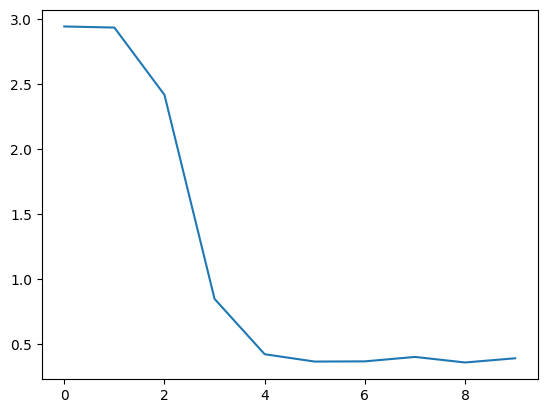

In [26]:
# Plot history
plt.plot(loss_history)

Entraînez le modèle avec des batchs de X, y

### Amélioration du modèle

Tenter d'améliorer le modèle:
- En utilisant plusieurs layers dans le RNN
- En utilisant LSTM à la place de RNN (une autre forme de recurrent neural network, plus avancé)

(regardez la doc)

In [27]:
class RNNNetwork2(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.rnn = torch.nn.LSTM(input_size, hidden_size)
        self.out_layer = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        # start RNN
        output, _ = self.rnn(X)
        # end RNN
        output = self.out_layer(output)
        return torch.nn.LogSoftmax()(output)

In [28]:
model = RNNNetwork2(n_letters, 128, n_categories).to("cuda")
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10

In [29]:
loss_history = []
for i in range(n_epochs):
    for X_batch, y_batch in tqdm(data_loader):
        X_batch, y_batch = X_batch.to("cuda"), y_batch.to("cuda")
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
    
    loss_history.append(loss.item())
    print("Loss: ", loss.item())

  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  2.432222604751587


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  1.525861144065857


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  1.505256175994873


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  1.2938051223754883


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  1.0232172012329102


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.7794187664985657


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.8195410966873169


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.924493134021759


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.6051846742630005


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.8901687264442444


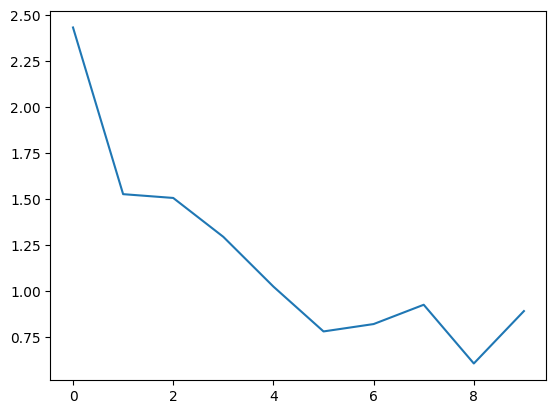

In [30]:
# Plot history
plt.plot(loss_history)

### Embedding

On veut utiliser en embedding pour les lettres.
Le forward appliquerait l'embedding aux lettres, puis les layers RNN prendrait l'embedding comme input

Nous allons utiliser torch.nn.Embedding
**Attention**: Embedding ne prend pas les lettres one-hot encoded, mais leurs indices.
Par exemple, "abca", il lui faudrait le vecteur [0, 1, 2, 0]<br>
et non [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]]

**Expérimenter torch.nn.Embedding**<br>
Instantier "emb" une torch.nn.Embedding avec les bons paramètres (regardez la doc)
En construisant le bon tenseur X_emb,

```emb(X_emb)```

doit retourner un tenseur (qui n'a pas de sens car il n'a rien appris pour l'instant, mais les opérations se passent bien)

In [31]:
class RNNWithEmbedding(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.embedding = torch.nn.Embedding(input_size, hidden_size)
        self.rnn = torch.nn.LSTM(hidden_size, hidden_size)
        self.out_layer = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        # start RNN
        X = self.embedding(X)
        output, _ = self.rnn(X)
        # end RNN
        output = self.out_layer(output)
        return torch.nn.LogSoftmax()(output)

Construisez un modèle RNN, où les lettres passent par l'embedding avant d'être envoyées dans les couches de RNN.
Construisez une loop d'apprentissage

Expérimentez plusieurs valeurs pour le nombre de couche, la taille d'embedding ou les tailles d'hidden state.<br>
Quel neg log likelihood obtenez-vous ?

In [32]:
model = RNNWithEmbedding(n_letters, 128, n_categories).to("cuda")
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 15

In [33]:
loss_history = []
for i in range(n_epochs):
    for X_batch, y_batch in tqdm(data_loader):
        
        X_batch, y_batch = torch.argmax(X_batch, dim=-1).to("cuda"), y_batch.to("cuda")
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
    
    loss_history.append(loss.item())
    print("Loss: ", loss.item())

  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  1.146543025970459


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.9783899784088135


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  1.0296306610107422


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  1.0231839418411255


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.8428038358688354


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.9343216419219971


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.7157014012336731


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.94220370054245


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.5918781161308289


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.7522813677787781


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.7256812453269958


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  1.127070665359497


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.884828507900238


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.6390148997306824


  0%|          | 0/157 [00:00<?, ?it/s]

Loss:  0.5144593119621277


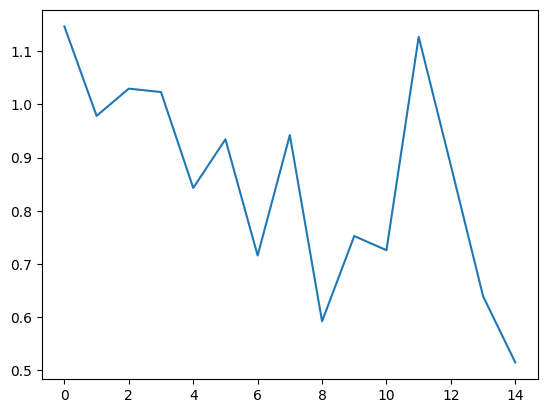

In [34]:
# Plot history
plt.plot(loss_history)